<div style="background-color:white; height=110%;">
<p align="center">
    <img src="./logo_cropped.png" width=120>
</p>

<center>
<par style="color:#56007c;">
<b>Hephaestus Applied Artificial Intelligence Association</b>
</par>
</div>

</br>
<center>
<h1 style="margin:0;"><b>Automatic Quiz Scoring</b></h1>
<h3 style="margin:0;">Spring 2024</h3>
<h5>Straccialini Samuele Nicolò<br>Guidotti Sofia<br>Casillo Francesca<br>Todorova Velina</h5>

# Import Libraries

In [1]:
!pip install opencv-python
!pip install pdf2image
!pip install numpy
!pip install pandas
!pip install scikit-learn
!pip install emnist
!pip install matplotlib
!pip install joblib

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [3]:
import os
import cv2
import pdf2image
import numpy as np
import pandas as pd
import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import SGDClassifier
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn import svm
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(color_codes=True)
from IPython.display import Image
from skimage.transform import resize 
from skimage.io import imread 

C:\Users\stras\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset preprocessing

The following blocks of code preprocess our dataset. All files are converted to <code>jpeg</code> format $-$ in particular PDF's pages are splitted and saved separately. Then the answer table area is extracted through a Cascade Classifier.

In [3]:
# Read uploaded files and get jpeg images. Accepted types: jpeg, jpg, png, PDF
def extract_images(out_folder, in_folder='0_raw_dataset'):
    """
    Takes input files and convert them to jpeg.
    Uploads output jpeg files to desired output folder.
    Pictures are numbered. Pictures extracted from a PDF are numbered both by file and page

    Parameters
    ----------
    out_folder : str
        The folder to which upload output pictures
    """

    raw_files = os.listdir(in_folder)
    file_num = 1
    for file in raw_files:
        print(f'Processing file {file}')
        ext = file.split('.')[-1]

        # jpg or jpeg
        if ext.lower() == 'jpg' or ext.lower() == 'jpeg':
            img = cv2.imread(f'{in_folder}/{file}')
            cv2.imwrite(f'{out_folder}/{file_num}.jpeg', img)

        # png
        elif ext.lower() == 'png':
            img = cv2.imread(f'{in_folder}/{file}')
            cv2.imwrite(f'{out_folder}/{file_num}.jpeg', img, [int(cv2.IMWRITE_JPEG_QUALITY), 100])

        # pdf
        elif ext.lower() == 'pdf':
            pages = pdf2image.convert_from_path(f'{in_folder}/{file}', poppler_path='poppler-24.02.0/Library/bin')
            page_num = 1
            for page in pages:
                page.save(f'{out_folder}/{file_num}_{page_num}.jpeg', 'JPEG')
                page_num += 1

        print('Done.')
        file_num += 1

extract_images('1_files')

Processing file 4F.jpeg
Done.
Processing file AnyScanner_12_08_2023.pdf
Done.
Processing file Balla coi lupi.jpeg
Done.
Processing file biennio.pdf
Done.
Processing file BRNB4220050E078_000492.pdf
Done.
Processing file Campionati della Cultura e del Talento.pdf
Done.
Processing file CAMPIONATI DELLA CULTURA E TALENTO (4) - Copia.pdf
Done.
Processing file CAMPIONATI DELLA CULTURA E TALENTO (5).pdf
Done.
Processing file CAMPIONATI DELLA CULTURA E TALENTO (6).pdf
Done.
Processing file CAMPIONATI DELLA CULTURA E TALENTO (7).pdf
Done.
Processing file CAMPIONATI DELLA CULTURA E TALENTO (8).pdf
Done.
Processing file Digitalizzato_20231207-1034.pdf
Done.
Processing file doc02089720231207135639.pdf
Done.
Processing file doc02089820231207135652.pdf
Done.
Processing file doc02089920231207135705.pdf
Done.
Processing file doc06492920231205133204.pdf
Done.
Processing file DOC4.pdf
Done.
Processing file DOC5.pdf
Done.
Processing file DOC6.pdf
Done.
Processing file DOC7.pdf
Done.
Processing file Donne

In [4]:
def crop_images(input_folder, output_folder):
    """
    Finds area of interest from images applying a classifier and crops images accordingly.
    Also, images are filtered and rotated. Images are saved in the desired folder

    Parameters
    ----------
    input_folder : str
        The folder from which import pictures
    output_folder : str
        The folder to which upload output pictures
    """

    classifier = cv2.CascadeClassifier('cascade/classifier/cascade.xml')

    for filename in os.listdir(input_folder):
        image_path = os.path.join(input_folder, filename)

        image = cv2.imread(image_path)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # creates a box taking the coordinates of the furthest to the right, left, top and bottom objects
        objects = classifier.detectMultiScale(gray)
        if len(objects) == 4:
            x_min = min(objects[:, 0])
            y_min = min(objects[:, 1])
            x_max = max(objects[:, 0] + objects[:, 2])
            y_max = max(objects[:, 1] + objects[:, 3])


            # get points
            s_objects = objects[np.lexsort(np.fliplr(objects).T)]
            if s_objects[0,1] < s_objects[1,1]:
                p1 = [s_objects[0,0], s_objects[0,1]]
                p3 = [s_objects[1,0], s_objects[1,1] + s_objects[1,3]]
            else:
                p1 = [s_objects[1,0], s_objects[1,1]]
                p3 = [s_objects[0,0], s_objects[0,1] + s_objects[0,3]]

            if s_objects[2,1] < s_objects[3,1]:
                p2 = [s_objects[2,0] + s_objects[2,2], s_objects[2,1]]
                p4 = [s_objects[3,0] + s_objects[3,2], s_objects[3,1] + s_objects[3,3]]
            else:
                p2 = [s_objects[3,0] + s_objects[3,2], s_objects[3,1]]
                p4 = [s_objects[2,0] + s_objects[2,2], s_objects[2,1] + s_objects[2,3]]

            points = np.array([p2, p4, p3, p1], np.float32)
            (tl, tr, br, bl) = points

            widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
            widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
            maxWidth = max(int(widthA), int(widthB))

            heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
            heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
            maxHeight = max(int(heightA), int(heightB))

            dst = np.array([
                [0, 0],
                [maxWidth - 1, 0],
                [maxWidth - 1, maxHeight - 1],
                [0, maxHeight - 1]], dtype = "float32")

            # compute the perspective transform matrix and then apply it
            M = cv2.getPerspectiveTransform(points, dst)
            warped = cv2.warpPerspective(gray, M, (maxWidth, maxHeight))

            # detects rotated files and adjust them
            if image.shape[1]>image.shape[0]:
                if x_min < image.shape[1] - x_max:
                    warped = cv2.rotate(warped, cv2.ROTATE_90_COUNTERCLOCKWISE)
                else:
                    warped = cv2.rotate(warped, cv2.ROTATE_90_CLOCKWISE)
                print(' rotated ↴')

            warped = cv2.rotate(warped, cv2.ROTATE_90_CLOCKWISE)
            warped = cv2.resize(warped, (1400, 1870)) 

            cropped_filename = os.path.join(output_folder, f"cropped_{filename}")

            cv2.imwrite(cropped_filename, warped)
            print(f"Saved cropped image: {cropped_filename}")

crop_images('1_files', '2_cropped')

Saved cropped image: 2_cropped\cropped_1.jpeg
Saved cropped image: 2_cropped\cropped_10_1.jpeg
Saved cropped image: 2_cropped\cropped_11_1.jpeg
Saved cropped image: 2_cropped\cropped_12_1.jpeg
Saved cropped image: 2_cropped\cropped_12_2.jpeg
Saved cropped image: 2_cropped\cropped_12_3.jpeg
Saved cropped image: 2_cropped\cropped_12_4.jpeg
Saved cropped image: 2_cropped\cropped_12_5.jpeg
Saved cropped image: 2_cropped\cropped_12_6.jpeg
Saved cropped image: 2_cropped\cropped_12_7.jpeg
Saved cropped image: 2_cropped\cropped_12_8.jpeg
Saved cropped image: 2_cropped\cropped_12_9.jpeg
Saved cropped image: 2_cropped\cropped_13_1.jpeg
Saved cropped image: 2_cropped\cropped_14_1.jpeg
Saved cropped image: 2_cropped\cropped_15_1.jpeg
Saved cropped image: 2_cropped\cropped_16_1.jpeg
Saved cropped image: 2_cropped\cropped_16_10.jpeg
Saved cropped image: 2_cropped\cropped_16_11.jpeg
Saved cropped image: 2_cropped\cropped_16_12.jpeg
Saved cropped image: 2_cropped\cropped_16_2.jpeg
Saved cropped image:

In [11]:
def apply_mask(image_path):
    """
    Mask is applied to image to extract table entries

    Parameters
    ----------
    image_path : str
        The picture you want to apply mask to

    Returns
    -------
    list
        a list of coordinates of the boxes
    """

    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    mask = cv2.imread('mask.png',0)
    res = cv2.bitwise_and(img, img, mask = mask)

    connected_components = cv2.connectedComponentsWithStats(res, 4, cv2.CV_32S)

    boxes = get_boxes(connected_components)
    return boxes


def get_boxes(connected_components):
    """
    Obtains box coordinates

    Parameters
    ----------
    connected_components : Array
        cv2.connectedComponentsWithStats Object

    Returns
    -------
    list
        a list of coordinates of the boxes
    """

    (totalLabels, label_ids, values, centroid) = connected_components

    slots = []
    coef = 1

    for i in range(1, totalLabels):

        x1 = int(values[i, cv2.CC_STAT_LEFT] * coef)
        y1 = int(values[i, cv2.CC_STAT_TOP] * coef)
        w = int(values[i, cv2.CC_STAT_WIDTH] * coef)
        h = int(values[i, cv2.CC_STAT_HEIGHT] * coef)

        slots.append([x1,y1,w,h])

    return slots


def classify(input_folder, output_folder):
    """
    Stores each box in a separate file

    Parameters
    ----------
    input_folder : str
        The folder from which import pictures
    output_folder : str
        The folder to which upload output pictures
    """

    for filename in os.listdir(input_folder):
        image_path = os.path.join(input_folder, filename)

        boxes = apply_mask(image_path)
        print(f'{filename}: {boxes}')
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        boxes_sorted = sort_boxes(boxes)

        count = 0
        for box in boxes_sorted:

            cv2.imwrite(f'{output_folder}/' + filename.replace('.jpeg', f'_{count}.jpeg'), image[box[1]:box[1]+box[3], box[0]:box[0]+box[2]])

            count += 1


def sort_boxes(boxes):
    """
    Sorts boxes according to their coordinates

    Parameters
    ----------
    boxes : list
        list of boxes' coordinates

    Returns
    -------
    list
        a list of sorted boxes
    """

    boxes_df = pd.DataFrame(boxes)
    return boxes_df.sort_values([0,1]).to_numpy()

classify('2_cropped', '3_labelling_img')

cropped_1.jpeg: [[1254, 439, 130, 95], [154, 445, 131, 95], [523, 445, 130, 95], [888, 445, 131, 95], [1254, 539, 130, 96], [154, 545, 131, 96], [523, 545, 130, 96], [888, 545, 131, 96], [1254, 640, 130, 96], [154, 646, 131, 96], [523, 646, 130, 96], [888, 646, 131, 96], [1254, 741, 130, 96], [154, 747, 131, 96], [523, 747, 130, 96], [888, 747, 131, 96], [1254, 842, 130, 96], [154, 848, 131, 96], [523, 848, 130, 96], [888, 848, 131, 96], [1254, 943, 130, 96], [154, 949, 131, 96], [523, 949, 130, 96], [888, 949, 131, 96], [1254, 1044, 130, 95], [154, 1050, 131, 95], [523, 1050, 130, 95], [888, 1050, 131, 95], [1254, 1145, 130, 95], [154, 1151, 131, 95], [523, 1151, 130, 95], [888, 1151, 131, 95], [1254, 1246, 130, 95], [154, 1252, 131, 95], [523, 1252, 130, 95], [888, 1252, 131, 95], [1254, 1346, 130, 96], [154, 1352, 131, 96], [523, 1352, 130, 96], [888, 1352, 131, 96], [1254, 1447, 130, 96], [154, 1453, 131, 96], [523, 1453, 130, 96], [888, 1453, 131, 96], [154, 1554, 131, 96], [523, 

# Data Analysis

After labelling each answer box (you can read more details about this in <i>Section 2.5</i> of the report) we obtained the dataset <code>IMG.csv</code>. In the next few blocks we will import that dataset containing just filenames and relative labels and combine it with the dataset made of pictures details.

In [4]:
df = pd.read_csv('IMG.csv', index_col=0)
df

,NAME,LABEL
ID,,
1,cropped_10_1_0.jpeg,D
2,cropped_10_1_1.jpeg,A
3,cropped_10_1_10.jpeg,D
4,cropped_10_1_11.jpeg,A
5,cropped_10_1_12.jpeg,B
...,...,...
11845,cropped_9_1_5.jpeg,C
11846,cropped_9_1_6.jpeg,A
11847,cropped_9_1_7.jpeg,X


In [5]:
df['LABEL'].value_counts()

LABEL
B    2529
A    2461
C    2430
D    1974
0    1747
X     704
x       2
Z       1
E       1
Name: count, dtype: int64

The dataset contains a good number of samples of each label "A", "B", "C", "D", "0" (empty cells). The label "X" refers to unrecognizable/cancelled letters: we will exclude this samples from the analysis.

We notice there have been some problems with some labels and try to correct them.

                     NAME LABEL
ID                             
3651  cropped_27_2_0.jpeg     Z


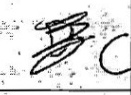

                     NAME LABEL
ID                             
5164  cropped_2_2_23.jpeg     E


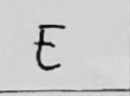

In [6]:
lab = df['LABEL'].replace('x', 'X')
df['LABEL'] = lab

print(df.loc[df['LABEL'] == 'Z'])
name1 = df.loc[df['LABEL'] == 'Z']['NAME'].tolist()[0]
display(Image(filename=f'3_labelling_img/{name1}'))

print(df.loc[df['LABEL'] == 'E'])
name2 = df.loc[df['LABEL'] == 'E']['NAME'].tolist()[0]
display(Image(filename=f'3_labelling_img/{name2}'))

In [7]:
# Correct missclassified samples
df.loc[df['NAME'] == name1, 'LABEL'] = 'X'
df.loc[df['NAME'] == name2, 'LABEL'] = 'E'
df['LABEL'].unique()

array(['D', 'A', 'B', 'C', 'X', '0', 'E'], dtype=object)

In [8]:
# Keep the LABELs of interest
df = df[df['LABEL'].isin(['A', 'B', 'C', 'D', '0'])]

# Create a dataframe with images details and the corresponding labels
flat_data_arr=[]
for i in df.index:
    name = df.loc[i]['NAME']

    img_array = imread(f'3_labelling_img/{name}') 
    img_resized = resize(img_array,(96,130,3))
    flat_data_arr.append(img_resized.flatten())

flat_data = np.array(flat_data_arr)

img_df = pd.concat([pd.DataFrame(df.index), pd.DataFrame(flat_data)], axis=1)

In [9]:
df = pd.merge(df, img_df, on='ID')
df

,ID,NAME,LABEL,0,1,2,3,4,5,6,...,37430,37431,37432,37433,37434,37435,37436,37437,37438,37439
0,1,cropped_10_1_0.jpeg,D,0.988200,0.988200,0.988200,0.984268,0.984268,0.984268,0.980317,...,0.181712,0.142213,0.142213,0.142213,0.567656,0.567656,0.567656,0.885089,0.885089,0.885089
1,2,cropped_10_1_1.jpeg,A,1.000000,1.000000,1.000000,0.999910,0.999910,0.999910,0.992081,...,0.196501,0.126848,0.126848,0.126848,0.567391,0.567391,0.567391,0.881161,0.881161,0.881161
2,3,cropped_10_1_10.jpeg,D,0.564615,0.564615,0.564615,0.540860,0.540860,0.540860,0.513424,...,0.220392,0.319306,0.319306,0.319306,0.844872,0.844872,0.844872,0.987707,0.987707,0.987707
3,4,cropped_10_1_11.jpeg,A,0.384314,0.384314,0.384314,0.384359,0.384359,0.384359,0.388235,...,0.356078,0.437406,0.437406,0.437406,0.850106,0.850106,0.850106,0.956471,0.956471,0.956471
4,5,cropped_10_1_12.jpeg,B,0.643152,0.643152,0.643152,0.647149,0.647149,0.647149,0.655354,...,0.278929,0.501357,0.501357,0.501357,0.862504,0.862504,0.862504,0.968235,0.968235,0.968235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11136,11843,cropped_9_1_48.jpeg,A,0.988235,0.988235,0.988235,0.988235,0.988235,0.988235,0.898039,...,0.968627,0.968627,0.968627,0.968627,0.972549,0.972549,0.972549,0.972549,0.972549,0.972549
11137,11844,cropped_9_1_49.jpeg,C,0.964706,0.964706,0.964706,0.988235,0.988235,0.988235,0.933333,...,0.976471,0.976471,0.976471,0.976471,0.980392,0.980392,0.980392,0.980392,0.980392,0.980392
11138,11845,cropped_9_1_5.jpeg,C,0.996078,0.996078,0.996078,0.996124,0.996124,0.996124,0.999925,...,0.564389,0.537783,0.537783,0.537783,0.335686,0.335686,0.335686,0.208326,0.208326,0.208326
11139,11846,cropped_9_1_6.jpeg,A,0.996078,0.996078,0.996078,0.996079,0.996079,0.996079,0.996174,...,0.936424,0.814184,0.814184,0.814184,0.214529,0.214529,0.214529,0.289878,0.289878,0.289878


In [10]:
# Split in features and labels dataframes
X = df.iloc[:,3:]
y = df['LABEL']

### Data Visualization

In [11]:
letter_dic = {}

for i in range(len(y)):
    if y[i] not in letter_dic.keys():
        letter_dic[y[i]] = []
    letter_dic[y[i]].append(i)

print(letter_dic)

{'D': [0, 2, 15, 27, 41, 42, 45, 47, 53, 54, 63, 67, 74, 77, 82, 87, 90, 95, 97, 105, 114, 115, 119, 127, 135, 137, 146, 148, 150, 151, 156, 161, 177, 190, 195, 197, 201, 209, 212, 215, 225, 230, 234, 238, 261, 274, 282, 284, 294, 323, 324, 335, 338, 342, 347, 365, 373, 377, 383, 384, 395, 396, 399, 400, 411, 417, 422, 423, 436, 450, 467, 472, 474, 481, 483, 484, 491, 493, 499, 501, 506, 507, 512, 517, 522, 523, 524, 529, 530, 531, 532, 533, 545, 546, 556, 557, 572, 573, 579, 582, 590, 592, 595, 598, 605, 609, 611, 617, 621, 628, 631, 632, 635, 637, 650, 655, 671, 695, 699, 705, 708, 709, 717, 718, 721, 726, 731, 732, 745, 755, 760, 763, 771, 774, 781, 782, 785, 787, 790, 792, 795, 798, 799, 808, 809, 811, 831, 832, 835, 840, 841, 844, 848, 854, 857, 858, 862, 870, 873, 884, 886, 891, 894, 904, 920, 927, 931, 934, 936, 939, 940, 941, 944, 947, 949, 958, 970, 974, 980, 983, 987, 989, 992, 996, 1002, 1005, 1010, 1015, 1018, 1024, 1029, 1032, 1034, 1042, 1047, 1055, 1056, 1075, 1079, 1082

In [31]:
def run_PCA(df, n_components, plot=False):
    """
    Takes as input a dataframe and the number of principal components the
    PCA needs to find. Returns an Array with examples as rows and columns
    as principal components found i.e. an array of shape (N, n_components)
    """
    X = df.to_numpy()
    print('Original shape:', X.shape)
    pca = PCA(n_components = n_components)
    pca.fit(X)
    X = pca.fit_transform(X)
    print('Reduced shape:', X.shape)

    #joblib.dump(pca, 'PCA_model.pkl')

    explained_variance = pca.explained_variance_ratio_
    print('Explained variance per component:', explained_variance)
    print('Total explained variance:', sum(explained_variance))

    if plot:
        cumulative_explained_variance = np.cumsum(explained_variance)
        plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o')
        plt.xlabel('Number of Components')
        plt.ylabel('Cumulative Explained Variance')
        plt.title('PCA Explained Variance')
        plt.grid()
        plt.show()

    return X

Original shape: (11141, 37440)
Reduced shape: (11141, 3)
Explained variance per component: [0.408913   0.0408236  0.03498651]
Total explained variance: 0.48472311502738347


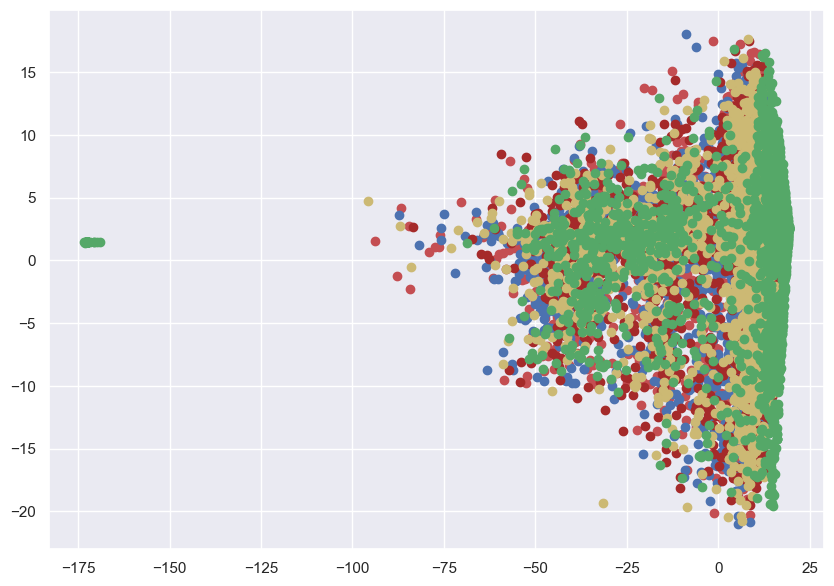

In [13]:
X_red = run_PCA(X, 3)

array_A = np.array([X_red[i] for i in letter_dic['A']])
array_B = np.array([X_red[i] for i in letter_dic['B']])
array_C = np.array([X_red[i] for i in letter_dic['C']])
array_D = np.array([X_red[i] for i in letter_dic['D']])
array_0 = np.array([X_red[i] for i in letter_dic['0']])

fig = plt.figure(figsize = (10, 7))
plt.scatter(array_A[:,0], array_A[:,1], color='r')
plt.scatter(array_B[:,0], array_B[:,1], color='b')
plt.scatter(array_C[:,0], array_C[:,1], color='brown')
plt.scatter(array_D[:,0], array_D[:,1], color='y')
plt.scatter(array_0[:,0], array_0[:,1], color='g')
plt.show()

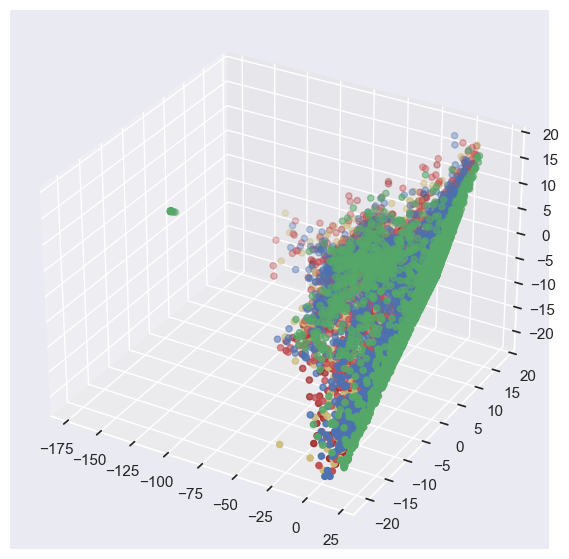

In [14]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

ax.scatter3D(array_A[:,0], array_A[:,1], array_A[:,1], color='r')
ax.scatter3D(array_B[:,0], array_B[:,1], array_B[:,1], color='b')
ax.scatter3D(array_C[:,0], array_C[:,1], array_C[:,1], color='brown')
ax.scatter3D(array_D[:,0], array_D[:,1], array_D[:,1], color='y')
ax.scatter3D(array_0[:,0], array_0[:,1], array_0[:,1], color='g')
plt.show()

Original shape: (11141, 37440)
Reduced shape: (11141, 400)
Explained variance per component: [4.08913004e-01 4.08235985e-02 3.49865126e-02 3.13658428e-02
 2.13773940e-02 2.03062433e-02 1.49293929e-02 1.47860393e-02
 1.35925758e-02 1.27984800e-02 1.07680177e-02 8.93151196e-03
 8.42498293e-03 8.05637343e-03 7.59800655e-03 7.30769372e-03
 6.67451222e-03 6.48060630e-03 5.88839967e-03 5.78010034e-03
 5.44897651e-03 4.80400563e-03 4.57947796e-03 4.47433203e-03
 4.12311859e-03 4.01584812e-03 3.74106011e-03 3.65939296e-03
 3.57109432e-03 3.48782152e-03 3.30567664e-03 3.26815340e-03
 3.14343347e-03 3.00892637e-03 2.87753832e-03 2.84310234e-03
 2.81237508e-03 2.65105986e-03 2.62664343e-03 2.62361162e-03
 2.52298182e-03 2.46213518e-03 2.44870805e-03 2.39103918e-03
 2.23599093e-03 2.20950043e-03 2.17664581e-03 2.12420980e-03
 2.06564334e-03 2.05584049e-03 1.99150557e-03 1.97538373e-03
 1.88513078e-03 1.86233044e-03 1.80492544e-03 1.74753970e-03
 1.71916535e-03 1.69715376e-03 1.67809707e-03 1.65303

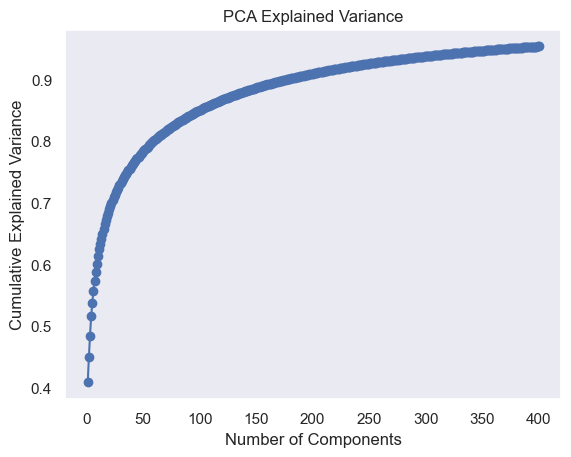

In [32]:
X_red = run_PCA(X, 400, True)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_red, y, random_state=42, stratify=y)

In the next blocks we will optimize SVM Classifier's parameter through GridSearch. If you wish to avoid this passage you can skip the next three block and run SVM with the optimal parameters we found.

In [ ]:
# Defining the parameters grid for GridSearchCV 
param_grid = {'C': [0.1,1,10,100],
              'gamma': [0.0001,0.001,0.1,1],
              'kernel': ['rbf','poly']} 
  
# Creating a support vector classifier 
SVC = svm.SVC(random_state=42) 
  
# Creating a model using GridSearchCV with the parameters grid 
model_SVC = GridSearchCV(SVC, param_grid, verbose=3)
# model_SVC = GridSearchCV(SVC, param_grid, verbose=3, n_jobs=-1)
# You may uncomment the previous line to use all your sistem processors and speed-up GridSearch.
# Note: remember to comment out line 12!

In [ ]:
model_SVC.fit(X_train, y_train)
model_SVC.best_params_ # {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}

In [ ]:
y_pred = model_SVC.predict(X_test)
accuracy = accuracy_score(y_test, y_pred) 
accuracy

In [18]:
SVC = svm.SVC(C=10, gamma=0.001, kernel='rbf').fit(X_train, y_train)
y_pred = SVC.predict(X_test)
accuracy = accuracy_score(y_test, y_pred) 
accuracy

0.7946877243359656

In [19]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       437
           A       0.74      0.81      0.78       615
           B       0.72      0.70      0.71       632
           C       0.86      0.86      0.86       608
           D       0.73      0.65      0.69       494

    accuracy                           0.79      2786
   macro avg       0.80      0.80      0.80      2786
weighted avg       0.79      0.79      0.79      2786



### SGD Classifier

In [ ]:
# Defining the parameters grid for GridSearchCV 
param_grid = {'loss': ['hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
              'penalty': ['l2', 'l1', 'elasticnet', None],
              'alpha': [0.0001, 0.001, 0.01],
              }

# Creating a support vector classifier 
SGD = SGDClassifier(random_state=42)

# Creating a model using GridSearchCV with the parameters grid 
model_SGD = GridSearchCV(SGD, param_grid, verbose=3)

In [ ]:
model_SGD.fit(X_train, y_train)
model_SGD.best_params_ # {'alpha': 0.01, 'loss': 'hinge', 'penalty': 'elasticnet'}

In [ ]:
y_pred = model_SGD.predict(X_test)
accuracy = accuracy_score(y_pred, y_test) 
accuracy

In [22]:
SGD = SGDClassifier(random_state=42, alpha= 0.01, loss='hinge', penalty='elasticnet').fit(X_train, y_train)
y_pred = SGD.predict(X_test)
accuracy = accuracy_score(y_pred, y_test) 
accuracy

0.6349605168700646

Finally, we export our trained classifier.

In [27]:
joblib.dump(SVC, 'SVC_model.pkl')

['SVC_model.pkl']